In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
# q4 Multivariate Gaussian

n = 10_000
rho = 0.9

# importance sampling
theta_x = 4
theta_y = 4

# generate random samples
x = np.random.normal(theta_x, 1, n)
y = rho * x + np.sqrt(1 - rho**2) * np.random.normal(theta_y, 1, n)

# compute tilt
exp_tilt = np.exp(
    0.5 * ((x**2 - (x - theta_x)**2) - (y**2 - (y - theta_y)**2))
)

prob = np.mean((x > 4) & (y > 4)) * np.mean(exp_tilt)
print("Estimated probability P(X > 4, Y > 4):", prob)

Estimated probability P(X > 4, Y > 4): 0.011022676840693243


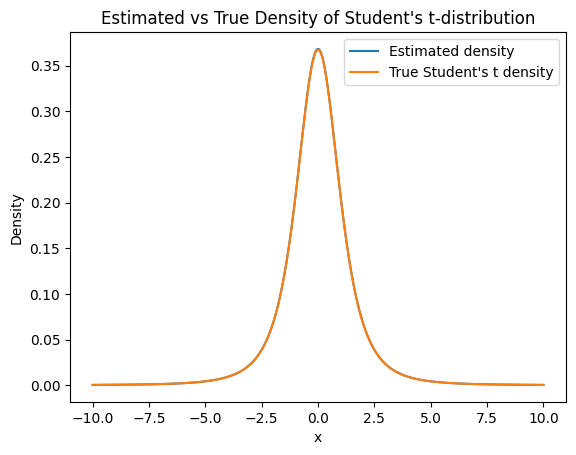

Estimated variance with Gaussian proposal density: 1.7666803214430398
Standard deviation of estimate with Gaussian proposal density: 0.07246036119891655
Estimated variance with Cauchy proposal density: 3.0045258797959398
Standard deviation of estimate with Cauchy proposal density: 0.0034389484496993848
True variance of Student's t-distribution: 3.0


In [4]:
# q6 Variance of a Student's t-distribution
n = 1_000_000
df = 3
density_kernel = lambda x: 1 / (1 + x**2/df)**2 

# normalizing constant
z = np.random.normal(0, 1, n)
z = density_kernel(z) / stats.norm.pdf(z)
z = np.mean(z)

density = lambda x: density_kernel(x) / z

# check density
x_vals = np.linspace(-10, 10, 1000)
plt.plot(x_vals, density(x_vals), label="Estimated density")
plt.plot(x_vals, stats.t.pdf(x_vals, df), label="True Student's t density")
plt.legend()
plt.title("Estimated vs True Density of Student's t-distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

# Estimating variance with Gaussian proposal density
x_gauss = np.random.normal(0, 1, n)
y2_mean_est = (x_gauss**2) * density(x_gauss) / stats.norm.pdf(x_gauss)
y_mean_est = (x_gauss) * density(x_gauss) / stats.norm.pdf(x_gauss)
var_est_gauss = np.mean(y2_mean_est) - np.mean(y_mean_est)**2
var_std_gauss = np.std(y2_mean_est - 2 * np.mean(y_mean_est) * y_mean_est) / np.sqrt(n)

print("Estimated variance with Gaussian proposal density:", var_est_gauss)
print("Standard deviation of estimate with Gaussian proposal density:", var_std_gauss)

# Estimating variance with Cauchy proposal density
x_cauchy = np.random.standard_cauchy(n)
y2_mean_est = (x_cauchy**2) * density(x_cauchy) / stats.cauchy.pdf(x_cauchy)
y_mean_est = (x_cauchy) * density(x_cauchy) / stats.cauchy.pdf(x_cauchy)
var_est_cauchy = np.mean(y2_mean_est) - np.mean(y_mean_est)**2
var_std_cauchy = np.std(y2_mean_est - 2 * np.mean(y_mean_est) * y_mean_est) / np.sqrt(n)

print("Estimated variance with Cauchy proposal density:", var_est_cauchy)
print("Standard deviation of estimate with Cauchy proposal density:", var_std_cauchy)

# true variance
true_var = df / (df - 2)
print("True variance of Student's t-distribution:", true_var)

Even with high number of samples, the estimate using a Gaussian proposal distribution is highly unstable as the tail regions are lighter than the student's t-distribution.

In [5]:
# q7 Enumerating Random Walks

m = 30

# generate walks with bias p
p = 0.7
steps = np.random.choice([1, -1], size=(n, m), p=[p, 1 - p])
walks = np.cumsum(steps, axis=1)

# tilt back to p = 0.5
tilt = (0.5 / p)**((steps == 1).cumsum(axis=1)) * (0.5 / (1 - p))**((steps == -1).cumsum(axis=1))

max_greater_20 = np.max(walks, axis=1) >= 20
tilted_indicator = max_greater_20 * tilt[:, -1]

# estimate probability of the maximum being at least 20
prob_est = np.mean(tilted_indicator)
prob_std = np.std(tilted_indicator) / np.sqrt(n)

# estimate the number of walks reaching at least 20
total_walks = 2**m
num_walks_est = prob_est * total_walks
num_walks_std = prob_std * total_walks
print("Estimated number of walks reaching at least 20:", num_walks_est)
print("Standard deviation of the estimate of number of walks:", num_walks_std)

# relative error
rel_error = num_walks_std / num_walks_est
print(f"Relative error of the estimate: {rel_error * 100:.4f}%")

Estimated number of walks reaching at least 20: 207324.72575334995
Standard deviation of the estimate of number of walks: 850.01445699065
Relative error of the estimate: 0.4100%


In [ ]:
from typing import List
from graphviz import Digraph

class Task:
    def __init__(self, id : int, dependencies : List | None = None, rvs=None):
        self.id = id
        self.start = None
        self.end = None
        self.dependencies = dependencies if dependencies is not None else []
        
        self.rvs = rvs if rvs is not None else (lambda : np.random.exponential(scale=1.0))

    def get_start(self):
        if self.start is None:
            if not self.dependencies:
                self.start = 0
            else:
                self.start = max(dep.get_end() for dep in self.dependencies)
        return self.start
    
    def get_end(self):
        if self.end is None:
            self.end = self.get_start() + self._simulate_duration()
        return self.end
    
    def reset(self):
        self.start = None
        self.end = None

    def _simulate_duration(self):
        u = self.rvs()
        return u
    
    def __str__(self):
        return f"Task {self.id}: start={self.get_start()}, end={self.get_end()}"
    

class PERT:
    def __init__(self, dependencies : List[List[int]], end : int, rvs=None):
        # dependencies e.g. [[0, 1], [-1, 0], [1, 2]] means task 0 has no dependencies, multiple dependencies are supported
        self.tasks = {}
        for i, j in dependencies:
            if i not in self.tasks and i != -1:
                self.tasks[i] = Task(i, rvs=rvs)
            if j not in self.tasks:
                self.tasks[j] = Task(j, rvs=rvs)
                
            if i != -1:
                self.tasks[j].dependencies.append(self.tasks[i])
        
        self.end = self.tasks[end]

    def simulate(self) -> float:
        self._reset()
        return self.end.get_end()

    def _reset(self) -> None:
        for task in self.tasks:
            task.reset()
        
    
    def get_importance_ratio(self, fn=None) -> float:
        if fn is None: return 1.0
        
        ratio = 1.0
        for task in self.tasks.values():
            u = task.end - task.start
            ratio *= fn(u)
        return ratio
    
    def render(self) -> None:
        # display using graphviz
            
        dot = Digraph(
            graph_attr={
                'rankdir': 'LR',
                'nodesep': '0.75',
                'ranksep': '1.25',
            }
        )
        for task in self.tasks.values():
            node = dot.node(
                str(task.id),
                f"{task.id}",
                shape='circle',
                width='0.3',
                height='0.3',
                fixedsize='true',
                xlabel=f"<<FONT POINT-SIZE='11'>({task.start:.3f},{task.end:.3f})</FONT>>",
            )

            for dep in task.dependencies:
                dot.edge(str(dep.id), str(task.id))
        
        # render the graph
        dot.render('pert_graph', format='png', cleanup=True)
       

# exponential with mean 2.0
proposal_pdf = lambda u: (1/2) * np.exp(-u/2)
proposal_rvs = lambda : np.random.exponential(scale=2.0)
importance_ratio_fn = lambda u: np.exp(-u) / proposal_pdf(u)

# example usage
dependencies = [(1, 2), (-1, 1), (2, 3)]
end_id = 3
threshold = 6.0

def simulate(dependencies, end_id, proposal_rvs, importance_ratio_fn, threshold, n_simulations=10_000):

    pert = PERT(dependencies, end_id, rvs=proposal_rvs)

    end_times = []
    ratios = []
    for _ in range(n_simulations):
        end_time = pert.simulate()
        ratio = pert.get_importance_ratio(importance_ratio_fn)
        end_times.append(end_time)
        ratios.append(ratio)

    end_times = np.array(end_times)
    ratios = np.array(ratios)

    # weighted mean
    mean_end_time = np.sum(end_times * ratios) / np.sum(ratios)

    # weighted std error
    std_end_time = np.sqrt(np.sum(ratios * (end_times - mean_end_time)**2) / np.sum(ratios)) / np.sqrt(n_simulations)


    print(f"Estimated project completion time: {mean_end_time} ± {std_end_time}")
    print(f"Relative error: {std_end_time / mean_end_time * 100:.4f}%")

    # probability that time exceeds
    prob_exceed = np.sum(ratios[end_times > threshold]) / np.sum(ratios)

    print(f"Estimated probability that project completion time exceeds {threshold} time units: {prob_exceed}")

    # render the PERT graph
    pert.render()

    # display image
    from IPython.display import Image
    Image("pert_graph.png")

simulate(dependencies, end_id, proposal_rvs, importance_ratio_fn, threshold, n_simulations=10_000)
    

Estimated project completion time: 2.9976289837249572 ± 0.017314120144123292
Relative error: 0.5776%
Estimated probability that project completion time exceeds 6.0 time units: 0.060975403421750146


In [8]:
from scipy.stats import expon

# q8 PERT
dependencies = [
    (-1, 1),
    (1, 2), (1, 3),
    (2, 4), (2, 5),
    (3, 6), (3, 7), (3, 8),
    (4, 10),
    (5, 9),
    (6, 9),
    (7, 9),
    (8, 10),
    (9, 10),
]
end_id = 10

# exponential with mean 2.5
mean = 2.5
proposal_pdf = lambda x: expon.pdf(x, scale=mean)
proposal_rvs = lambda : np.random.exponential(scale=2.5)
importance_ratio_fn = lambda u: np.exp(-u) / proposal_pdf(u)

threshold = 17.0

simulate(dependencies, end_id, proposal_rvs, importance_ratio_fn, threshold, n_simulations=10_000)

Estimated project completion time: 6.431733697340921 ± 0.022405908798002687
Relative error: 0.3484%
Estimated probability that project completion time exceeds 17.0 time units: 0.00047122833154542395
